We will perform sentiment analysis with IMDb. The workflow is as follows:
1. EDA & cleaning
2. Baseline linear model
3. LSTM model

In [2]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.73.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached 

  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import collections
import itertools
import os

In [5]:
reviews_train = []
for line in open(os.getcwd() + '/data/imbd_train.txt', 'r', encoding='latin1'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open(os.getcwd() + '/data/imbd_test.txt', 'r', encoding='latin1'):
    
    reviews_test.append(line.strip())

In [6]:
target = ["positive" if i < 12500 else "negative" for i in range(25000)]

In [7]:
df1 = pd.DataFrame({"review": reviews_train, "sentiment":target})
df2 = pd.DataFrame({"review": reviews_test, "sentiment":target})

In [8]:
df = pd.concat([df1, df2]).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [17]:
df

,review,sentiment,review_cleaned
0,"When I first saw the ad for this, I was like '...",positive,when i first saw the ad for this i was like oh...
1,"""A Girl's Folly"" is a sort of half-comedy, hal...",positive,a girl s folly is a sort of half comedy half m...
2,I started watching the show from the first sea...,positive,i started watching the show from the first sea...
3,This is a more interesting than usual porn mov...,positive,this is a more interesting than usual porn mov...
4,I suppose for 1961 this film was supposed to b...,negative,i suppose for this film was supposed to be coo...
...,...,...,...
49995,I saw this movie at midnight on On Demand the ...,positive,i saw this movie at midnight on on demand the ...
49996,"Some aspects of this production are good, such...",negative,some aspects of this production are good such ...
49997,I was not old enough to really appreciate the ...,negative,i was not old enough to really appreciate the ...
49998,Nice movie with a great soundtrack which spans...,positive,nice movie with a great soundtrack which spans...


# 1. EDA & cleaning

<Axes: xlabel='count', ylabel='sentiment'>

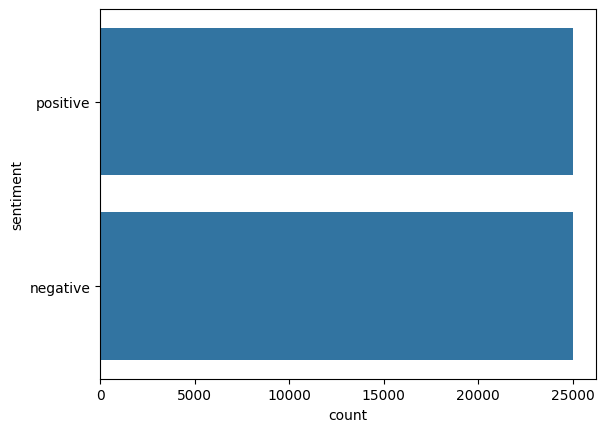

In [18]:
sns.countplot(df["sentiment"])

In [19]:
df.isna().sum()

review            0
sentiment         0
review_cleaned    0
dtype: int64

There is no null data.

### Text cleaning

In [20]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())

In [21]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

# 2. Baseline linear model

Before we build time-consuming neural network model, simple classifier is tried.
Tfidf method is used for text vectorization.

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6243
           1       0.89      0.91      0.90      6257

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



<Axes: >

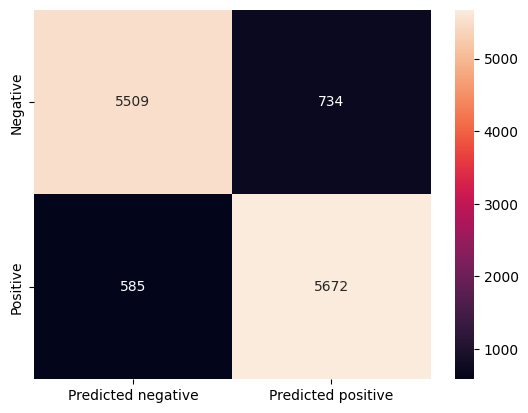

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'].map({'negative':0, 'positive':1}))
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Logistic regression provides 90% accuracy for test set, which is fast and adapted for such large datasets.

# 3. LSTM Long sort therm memory model

To quickly explore LSTM model, we firstly take only 500 characters. That is much faster way than taking full sentences.

In [23]:
df['review_cleaned_500'] = df['review_cleaned'].apply(lambda x:x[:500])

df['review_cleaned_500'][2]

'i started watching the show from the first season and at the beginning i was pretty skeptical about it original movie was kind of childish and i was just looking for some sci fi show while waiting for the bsg new season but after few episodes i became a fan i ve loved the characters the not so stupid as you think he is jack o neill the not only smart samantha carter the glorious teal c women and kids favorite and brilliant dr daniel jackson of course stories sometimes not serious sometimes even '

### Tokenize & Padding

Let's convert tokens to ID. We will use keras Tokenizer which can filter punctuations and take only most-counted 10000 words.

In [24]:
tokenizer = Tokenizer(num_words=10000)

In [25]:
tokenizer.fit_on_texts(df['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['review_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 116), X_min: 0, X_max: 9999


Sentiment is converted to 0 (negative) or 1 (positive).

In [26]:
y = df['sentiment'].map({'negative' : 0, 'positive' : 1}).values

Let's build the simple LSTM model using first 500 characters datasets.

In [50]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)


print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(32000, 116) (8000, 116) (10000, 116) (32000,) (8000,) (10000,)


In [46]:
y_train

array([1, 1, 0, ..., 0, 1, 0], shape=(30000,))

In [51]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Input(shape=(None,)),
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

c:\Users\maxi\miniconda3\envs\streamlit_env\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# X_train = X_train.reshape(-1, 1, 500)
# X_test = X_test.reshape(-1, 1, 500)
# X_valid = X_valid.reshape(-1, 1, 500)

In [53]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.6714 - loss: 0.5841 - val_accuracy: 0.8290 - val_loss: 0.3863
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8706 - loss: 0.3201 - val_accuracy: 0.8306 - val_loss: 0.3757
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9068 - loss: 0.2435 - val_accuracy: 0.8285 - val_loss: 0.4418
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9331 - loss: 0.1806 - val_accuracy: 0.8232 - val_loss: 0.5183
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9559 - loss: 0.1211 - val_accuracy: 0.8229 - val_loss: 0.5939


<Axes: >

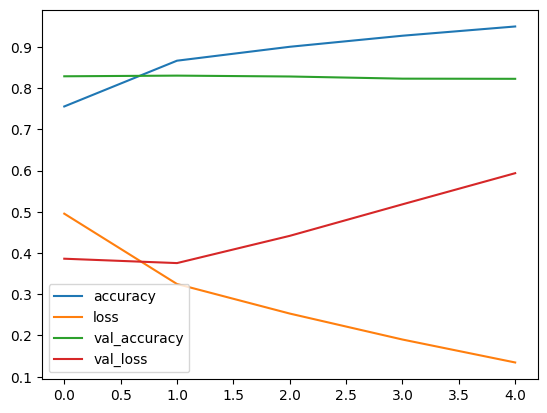

In [54]:
pd.DataFrame(history.history).plot()

This simple model is overfitted with training data as the validation loss increases.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4976
           1       0.00      0.00      0.00      5024

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



c:\Users\maxi\miniconda3\envs\streamlit_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maxi\miniconda3\envs\streamlit_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maxi\miniconda3\envs\streamlit_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

<Axes: >

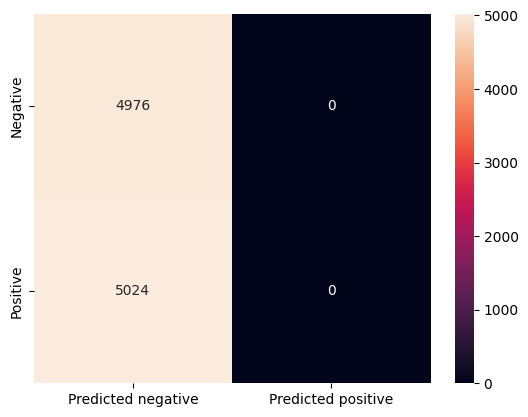

In [55]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Modified LSTM model

We added Dropout layers to prevent overfitting.

In [56]:
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

c:\Users\maxi\miniconda3\envs\streamlit_env\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20


500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.5377 - loss: 0.6875 - val_accuracy: 0.7492 - val_loss: 0.5354
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7731 - loss: 0.5519 - val_accuracy: 0.8070 - val_loss: 0.4621
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8198 - loss: 0.4764 - val_accuracy: 0.8249 - val_loss: 0.4302
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8391 - loss: 0.4246 - val_accuracy: 0.8270 - val_loss: 0.3941
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.8553 - loss: 0.3823 - val_accuracy: 0.8299 - val_loss: 0.3798
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8648 - loss: 0.3597 - val_accuracy: 0.8301 - val_loss: 0.3811
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8762 - loss: 0.3351 - val_accuracy: 0.8314 - val_loss: 0.3792
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.8758 - loss: 0.3279 - val_accurac

<Axes: >

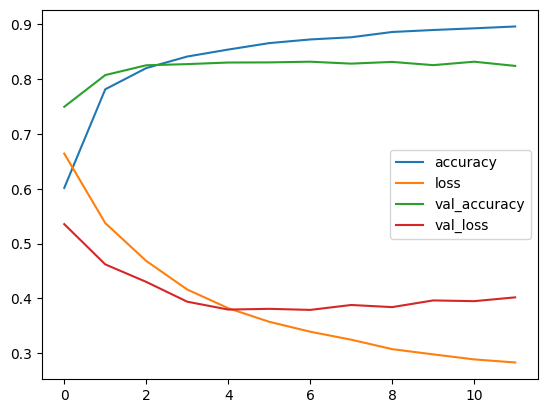

In [58]:
pd.DataFrame(history.history).plot()

Looks better than first model.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4961
           1       0.82      0.86      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



<AxesSubplot:>

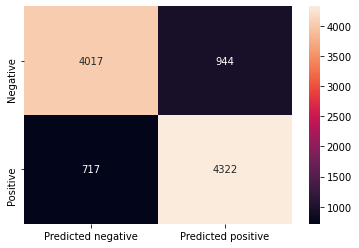

In [21]:
y_pred = model_v2.predict_classes(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Use of full-sentences would increase accurcy. But it is time-consuming and seems difficult to overwhelm simple Logistic regression model.